# TODO
    -Get the correct DRM
    -Generate new fits files


### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate(). NOTE: ADDED to tus_ASIM
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



# imports

In [31]:
import os
path = os.getcwd()

if path[1:5] == "Home":
    %run /Home/siv30/wad005/master/GRB/src/paths/uib.ipynb #UiB paths
else:
    %run /Users/andreas/phys/master/GRB/src/paths/mac.ipynb # Mac paths

All MAC paths are set!


In [32]:
%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb #MAC
%matplotlib inline

#%run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb #UiB
#pd.set_option('display.float_format', '{:.6E}'.format)
#pd.reset_option("all")

all UiB paths loaded
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


# NOTES ON GRB
    -Faint burst with relatively low countrate compared to the other bursts
    -Have all three instruments (ASIM/KW/FERMI)

## ASIM
    optimal tlagg = X [s]

Creating df for short GRB
Absolute time correction subtracted from T0
100 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 136 flags
Removed 136 flags from df
df sorted by tus
2019-06-06 01:55:07.318605
first tus:  -510549.72222222225 | max tus:  1499097.1666666667
16316
tus array OK ...


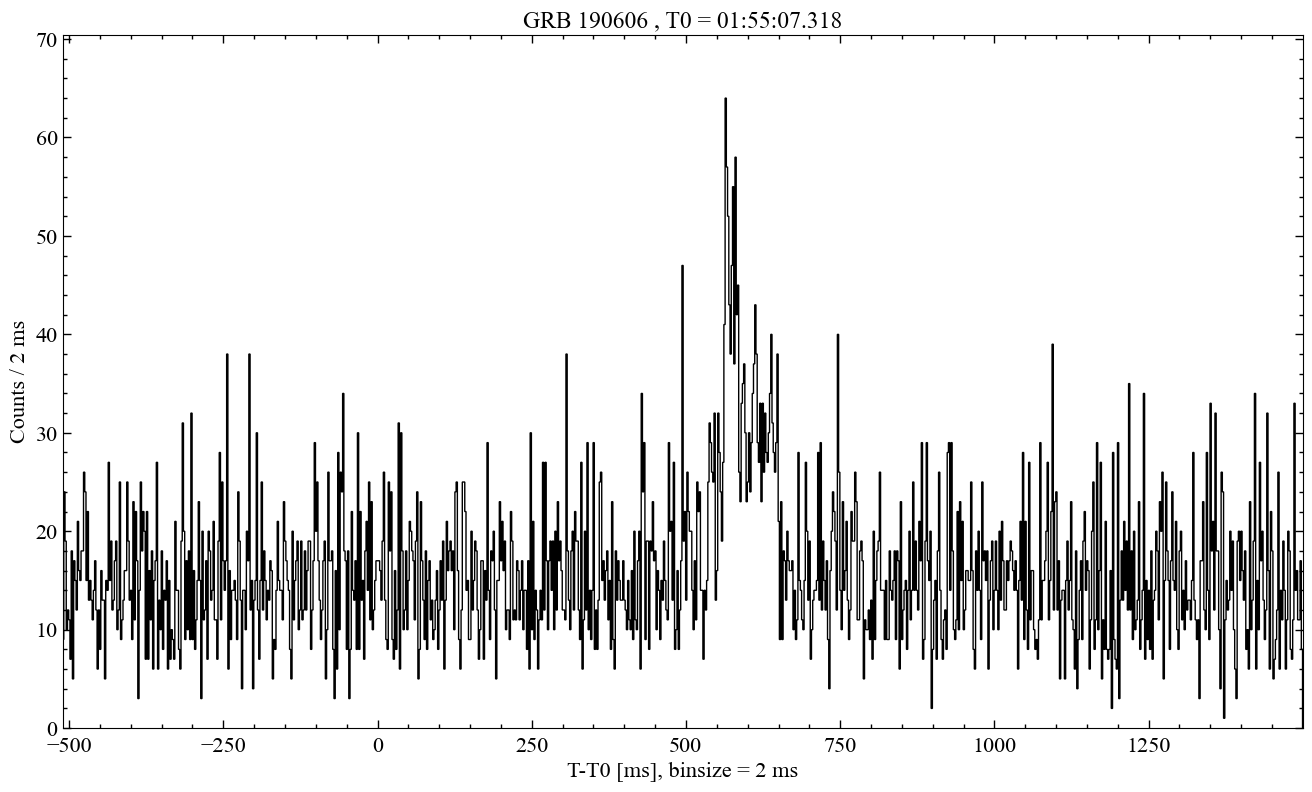

In [3]:
ASIM_df, T0_ASIM = complete_df(grb_id="GRB190606",remove_flag=True)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)
print(T0_ASIM)
print("first tus: ",min(tus),"| max tus: ", max(tus))
print(len(tus))
plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=2)

### ASIM tlagg approx

In [4]:
#calculating the tlagg approx based on trigger times and ToF
#bringing into KW ref frame...
#T0_ASIM = 01:55:07.318 abs time correction accounted for
#T0_KW = 01:55:03.800
#ToF = 4.0316
tlagg_approx = np.round(7.318-3.800-4.0316,4)
print(tlagg_approx)

-0.5136


## KW prep

bin start:  -0.512 bin end 0.512


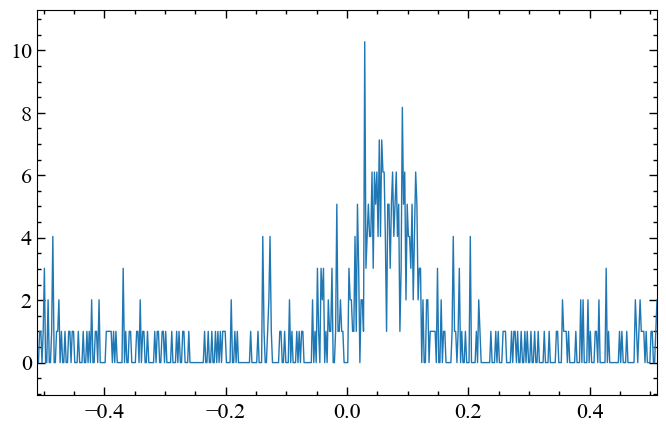

In [5]:
kw_filename = "GRB190606A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]
print("bin start: ", kw_bin_lo[0], "bin end",kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3
kwLC = LC(time=kw_bin_lo + binsize/2, counts=kwCounts, skip_checks=True,dt=binsize)
kwLC.plot()

asimBkg:  15.014836795252226


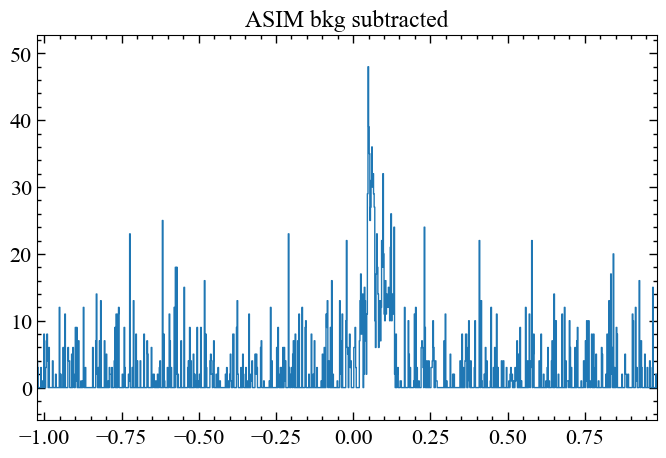

In [ ]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds

tus += tlagg_approx
asim_bins = np.round(np.arange(min(tus),max(tus)+binsize,binsize),3)
#kw_bins = np.append(kw_bin_lo,kw_bin_hi[-1])
hist = np.histogram(tus,bins=asim_bins)
asimCounts,asimEdges = hist[0],hist[1]

#NOTES: Too small of a interval to estimate the bkg. Need whole tus array to calculate on
#bkg_count pr bin = 15.0148
#kw_bin_lo[0] is in asim_binsOrg
iAsimBkgStart = find_nearest(asimEdges,min(asimEdges)+0.1)
iAsimBkgEnd = find_nearest(asimEdges,-0.25)

asimBkg = sum(asimCounts[iAsimBkgStart:iAsimBkgEnd])/len(asimCounts[iAsimBkgStart:iAsimBkgEnd])
print("asimBkg: ",asimBkg)
for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg

plt.step(x=asimEdges[:-1],y=asimCounts,where="pre")
plt.title("ASIM bkg subtracted")
plt.show()

## Comparing LC's with approx tshift

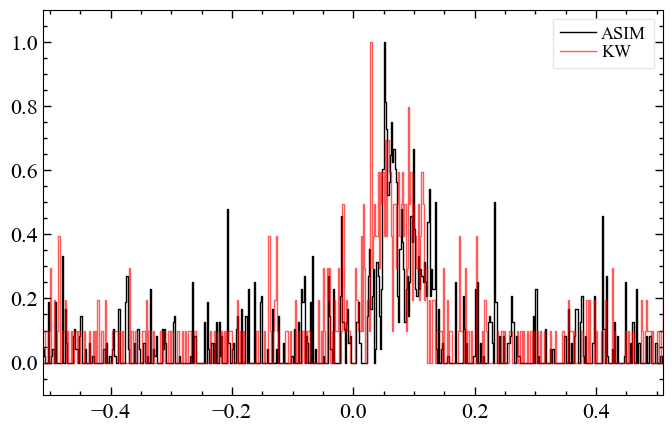

In [7]:
iAsimStart = find_nearest(asimEdges,kw_bin_lo[0])
iAsimEnd = find_nearest(asimEdges,kw_bin_lo[-1])

plt.step(x=asimEdges[iAsimStart:iAsimEnd],y=asimCounts[iAsimStart:iAsimEnd]/max(asimCounts),where="post",label="ASIM",color="black")
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),where="post",label="KW",color="red",alpha=0.65)
plt.legend()
plt.show()
#Good tlaggApprox, but ASIM needs to be shifted in + direction ~+0.03s

### building asimLC

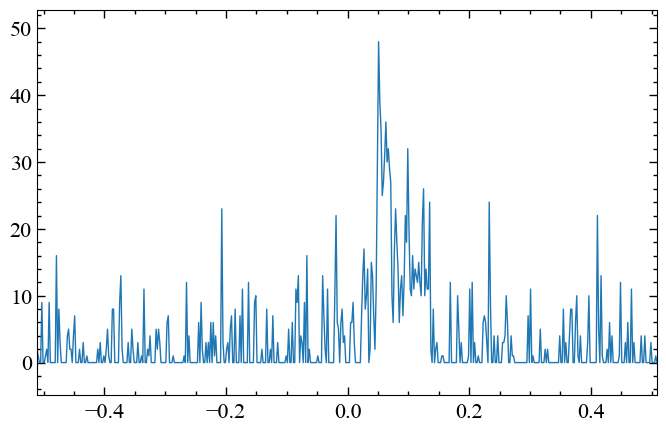

In [34]:
asimLC = LC(time=asimEdges[iAsimStart:iAsimEnd]+binsize/2,counts=asimCounts[iAsimStart:iAsimEnd],dt=0.002,skip_checks=True)
asimLC.plot()

asimLC.plot(labels=["T-T0 [s] ASIM ref. frame","counts/2ms"],title="GRB 201227A, ASIM 360-1360 keV",
            save=True,filename="/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorralation/ASIM_originalLC.png")

# CC
    Total tlagg after CC = -0.5366 s. 
    Hard to preform the CC since the data is very noisy and low countrate

Total lagg (s):  -0.5366225269343781 | CC lagg:  -0.023022526934378108


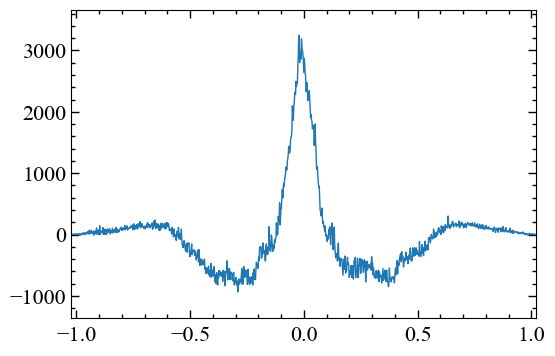

<AxesSubplot:>

In [36]:
CC = CrossCorrelation(kwLC,asimLC,mode="full")
CClagg=CC.time_shift
tlagg = tlagg_approx + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg)
CC.plot()

# Building final LC's

asimBkg:  15.0148


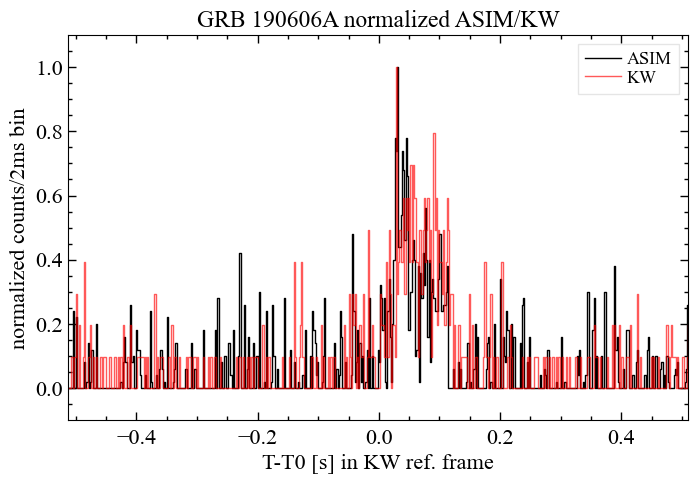

In [38]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds

tus += tlagg # -0.5366 s with 2ms bins

hist = np.histogram(tus,bins=asim_bins)
asimCounts,asimEdges = hist[0],hist[1]

asimBkg = 15.0148
print("asimBkg: ",asimBkg)
for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg

iAsimStart = find_nearest(asimEdges,kw_bin_lo[0])
iAsimEnd = find_nearest(asimEdges,kw_bin_hi[-1])

plt.step(x=asimEdges[iAsimStart:iAsimEnd],y=asimCounts[iAsimStart:iAsimEnd]/max(asimCounts),where="post",label="ASIM",color="black")
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),where="post",label="KW",color="red",alpha=0.65)

plt.title("GRB 190606A normalized ASIM/KW")
plt.xlabel("T-T0 [s] in KW ref. frame")
plt.ylabel("normalized counts/2ms bin")
#plt.vlines(x=0.0,ymin=0,ymax=1.1,color="g",label="T0: {}".format(T0_KW.isoformat(timespec="milliseconds")),alpha=0.6,linestyle="--")
plt.legend()
#plt.xlim(left=-0.1,right=0.2)
#plt.ylim(bottom=0,top=1.2)
#plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorrelation/overlappingLC_asim_kw.png")
plt.show()
#Ok CC! Have aligned the peak

# Extracting ASIM data

In [38]:
tlagg=np.round(-0.5366225269343781,4)
print(tlagg)

-0.5366


In [39]:
ASIM_df,T0 = complete_df(grb_id="GRB190606",remove_flag=True)
T0_shift = T0 + timedelta(seconds=tlagg)
ASIM_df["tus"] = ASIM_df["tus"].to_numpy()+tlagg*1e6

Creating df for short GRB
Absolute time correction subtracted from T0
100 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 136 flags
Removed 136 flags from df
df sorted by tus


tus array OK ...


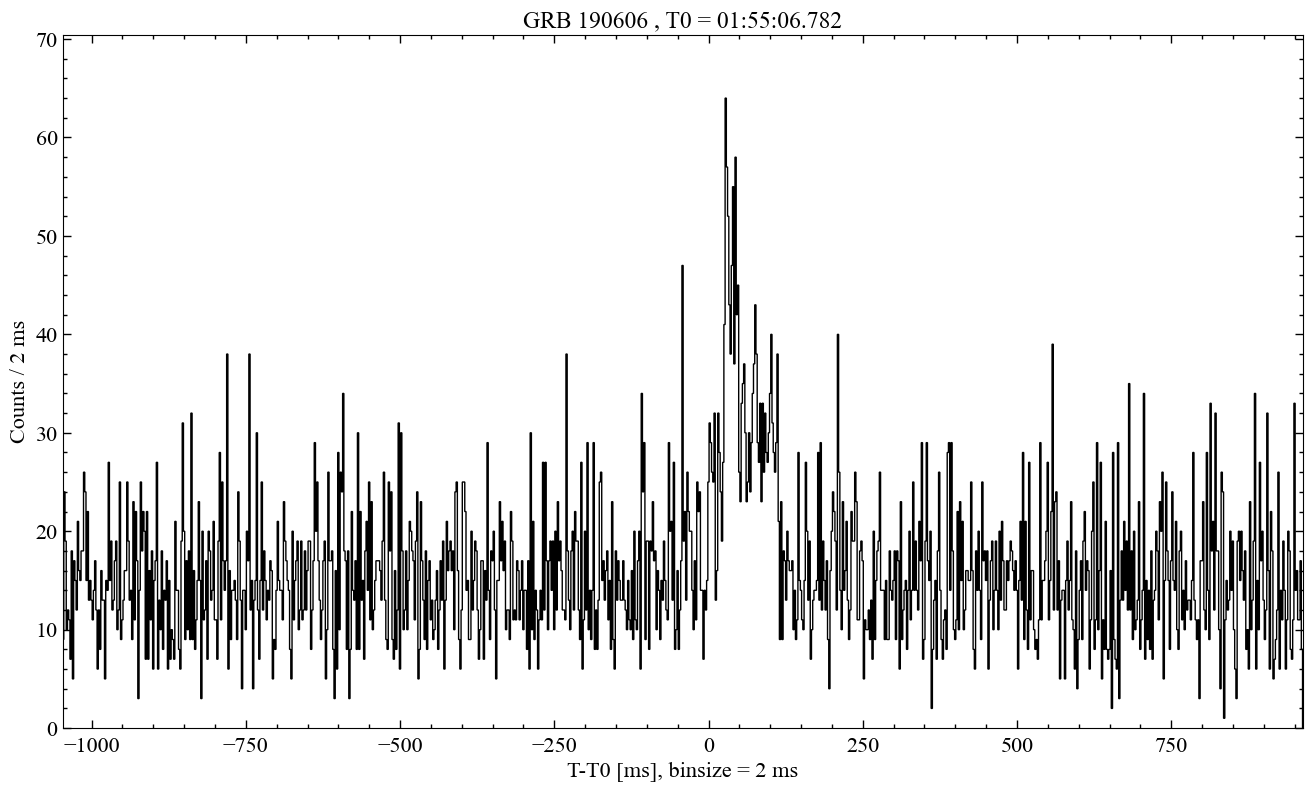

In [40]:
plot_HED(tus_arr=ASIM_df["tus"].to_numpy(),T0=T0_shift,binsize=2)
#maybe add a highlight key to show where the extracted interval is

In [ ]:
'2019-06-06T01:55:06.782'

In [41]:
keV_df,tus_check = keV_hist(df=ASIM_df,time_interval=(0,0.064),
                  keV_interval="max",
                  check_LC = True)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  1109
n triggers are within bounds  1109
keV bins are set for HED
Energies binned!


tus array OK ...


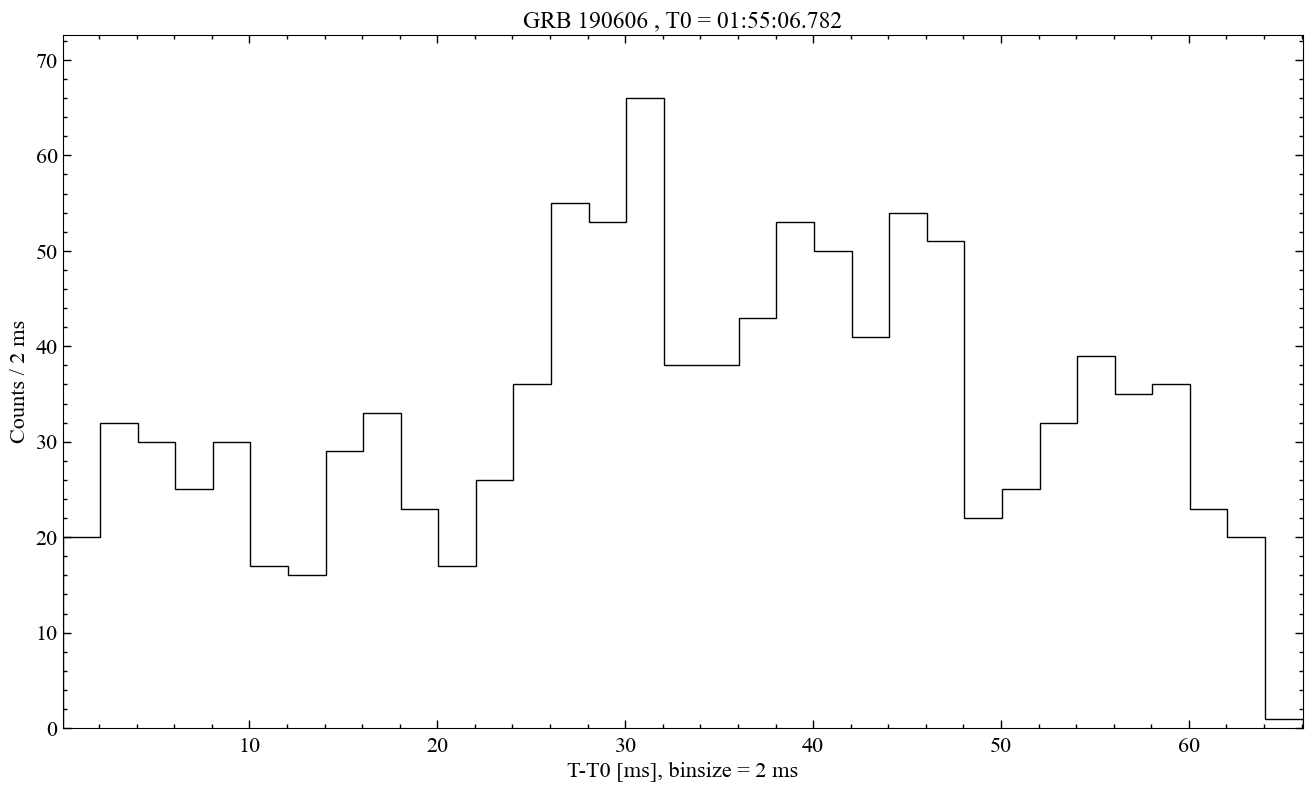

In [42]:
plot_HED(tus_arr=tus_check*1e6,T0=T0_shift,binsize=2)

### bakground extraction 

In [43]:
keV_bg,bg_LC = keV_hist(df=ASIM_df,time_interval=(-0.9,-0.1),
                 keV_interval="max",
                 check_LC=True)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  6057
n triggers are within bounds  6057
keV bins are set for HED
Energies binned!


tus array OK ...


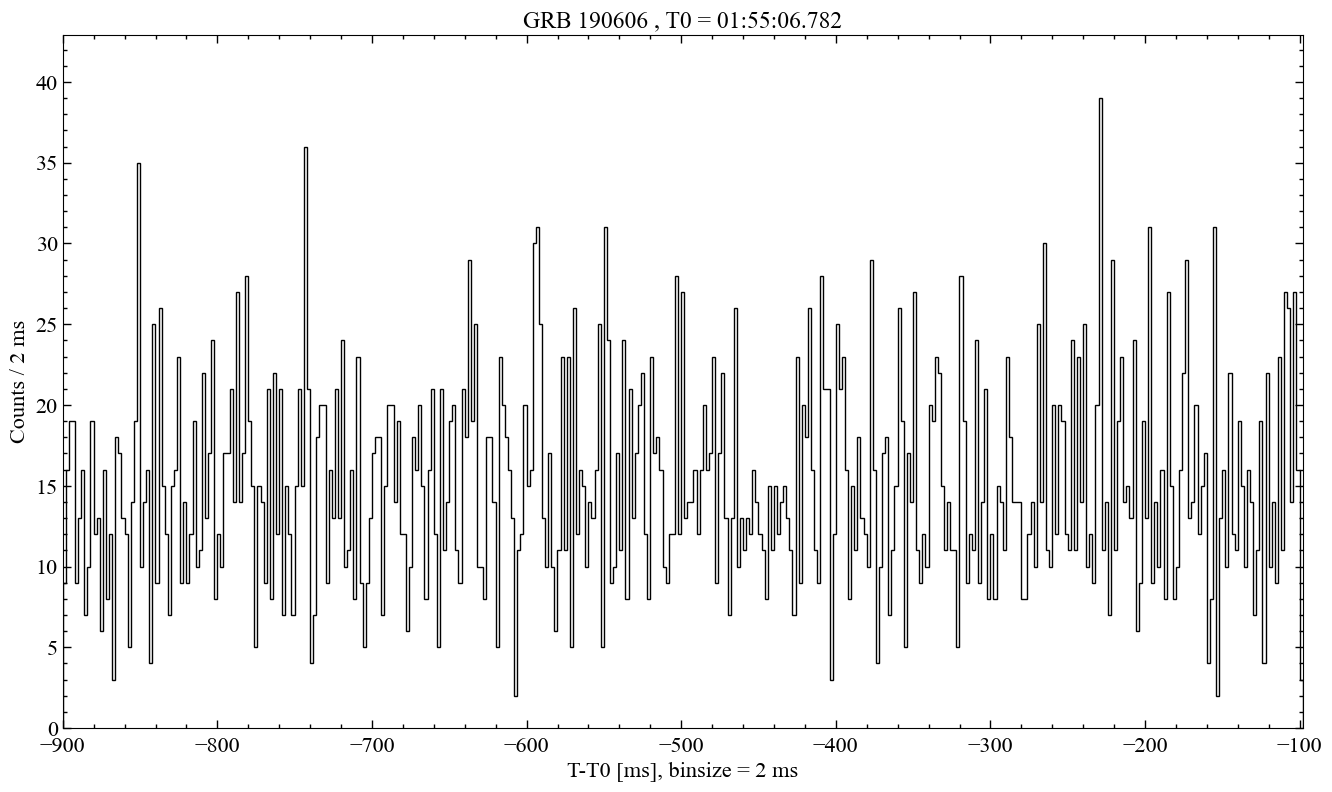

In [44]:
plot_HED(tus_arr=bg_LC*1e6,binsize=2,T0=T0_shift)

# Exporting fits files

In [45]:
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb

### PHA

In [46]:
T0_shift.isoformat()

'2019-06-06T01:55:06.782005'

In [75]:
pha_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-06-06T01:55:06.782','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.0,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [0.064,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.064,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190606A','Name of the observed object'], #<str> 
    'RA_OBJ': [313.330,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-30.510,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB190606.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB190606_phi_-30.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB190606_phi_-30.pha','PHA filename'] #<str>  ('example.pha')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [61]:
bin_lo = keV_df['bins_keV'].to_numpy()[:-1]
bin_hi = keV_df['bins_keV'].to_numpy()[1:]
counts = keV_df['counts'].to_numpy()[1:]
err = keV_df['poisson_error_counts'].to_numpy()[1:]

In [62]:
len(bin_lo),len(bin_hi),len(counts),len(err)

(40, 40, 40, 40)

In [76]:
generatePHA(PHA_dict=pha_dict,bin_lo=bin_lo,bin_hi=bin_hi,stat_err=err,counts=counts)

### BAK

In [52]:
bak_dict = {
'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
'T0TIME':['2019-06-06T01:55:06.782','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
'TSTART': [-0.9,'[s] Start time of background spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
'TSTOP': [-0.1,'End time of background spectrum accumulation'], #<float> [s]
'EXPOSURE': [0.8,'[s] Integration time in seconds for the BAK data'], #<float> 
'OBJECT': ['GRB190606A','Name of the observed object'], #<str> 
'RA_OBJ': [313.330,'[deg] RA of source'], #<float> 
'DEC_OBJ':  [-30.510,'[deg] Dec of source'], #<float>
'FILENAME': ['HED_GRB190606.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [53]:
bak_counts = keV_bg['counts'].to_numpy()[1:]
bak_err = keV_bg['poisson_error_counts'].to_numpy()[1:]

In [54]:
generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=bak_counts,stat_err=bak_err)

### RSP

In [77]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-02-06T03:49:28.230','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.00,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [0.064,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.064,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190606A','Name of the observed object'], #<str> 
    'RA_OBJ': [313.330,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-30.510,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB190606_phi_-30.rsp','RSP filename'] #<str>  ('example.pha')
}

In [56]:
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

In [78]:
theta,phi = 120.114,-30.00 #theta, phi angles for the incomming radiation reaching the ISS
drm_path = '/Users/andreas/phys/master/HED_DRM/'
drmfname = find_DRM_file(dir_path=drm_path,theta=theta,phi=phi)
print(drmfname)

HED_drm_mats_120.00_-30.00.txt


In [79]:
generateRSP(RSP_dict=rsp_dict,DRM_fname=drmfname,bin_lo=bin_lo,bin_hi=bin_hi,theta=theta,phi=phi)

# Fitting
    